In [17]:
import sys
from astropy import units as un, constants as cons
import numpy as np
from latexify import latexify

from astropy.visualization import quantity_support
quantity_support()
from matplotlib import pyplot as plt

sys.path.append('../pysrc/')
import cooling_flow as CF
import h5py

In [2]:
dataDir = '../cooling/Wiersma09_CoolingTables/'
f = h5py.File(dataDir+'z_0.000.hdf5','r')
f2 = h5py.File(dataDir+'z_collis.hdf5','r')

H_He_Cooling  = f['Metal_free']['Net_Cooling']
Tbins         = f['Metal_free']['Temperature_bins']
nHbins        = f['Metal_free']['Hydrogen_density_bins']
He_mf_bins    = f['Metal_free']['Helium_mass_fraction_bins']
Metal_Cooling = f['Total_Metals']['Net_cooling']

H_He_Cooling2  = f2['Metal_free']['Net_Cooling']
Metal_Cooling2 = f2['Total_Metals']['Net_cooling']

list(He_mf_bins)

[0.238, 0.248, 0.258, 0.268, 0.278, 0.288, 0.298]

In [81]:
print(Tbins[0], Tbins[-1])
print(nHbins[0], nHbins[-1])

100.0 959070000.0
1e-08 1.0


In [3]:
# we pick the second bin, since for Z=1, the value is around 0.25

In [4]:
def computeY(Z2Zsun):
    He2Habundance = 10**-1.07 * (0.71553 + 0.28447*Z2Zsun) #Asplund+09, Groves+04
    X = (1 - 0.014*Z2Zsun) / (1.+4.*He2Habundance)
    Y = 4.*He2Habundance * X
    return Y
print(computeY(1))

0.2504289874366739


In [5]:
def generate_header(arrays, filename):
    """
    Generates a C++ header file with constexpr arrays from given numpy arrays.
    Supports 1D, 2D, and 3D arrays.
    """
    with open(filename, "w") as f:
        f.write("#ifndef COOLING_TABLES_HPP\n")
        f.write("#define COOLING_TABLES_HPP\n\n")
        
        # Iterate over the arrays and write each to the header
        for name, array in arrays.items():
            array = np.array(array)
            dimensions = array.shape
            ndim = array.ndim  # Number of dimensions
            
            # Flatten the array into 1D for storage in C++
            flattened_array = array.flatten()
            
            # Write dimension sizes for each array
            f.write(f"// {name} dimensions\n")
            for i, dim in enumerate(dimensions):
                f.write(f"constexpr int {name}_DIM_{i} = {dim};\n")
            total_size = np.prod(dimensions)
            f.write(f"constexpr int {name}_TOTAL_SIZE = {total_size};\n\n")
            
            # Write the flattened array
            f.write(f"// Flattened {name} array in row-major order\n")
            f.write(f"constexpr Real {name}_ARR[{name}_TOTAL_SIZE] = {{\n")

            # Write the matrix values, nicely formatted
            for i, value in enumerate(flattened_array):
                f.write(f"{value}")
                if i < len(flattened_array) - 1:
                    f.write(",")
                if (i + 1) % dimensions[-1] == 0:  # Newline after each row or slice
                    f.write("\n")
                else:
                    f.write(" ")

            f.write("};\n\n")
        
        f.write("#endif // COOLING_TABLES_HPP\n")

    print(f"Header file '{filename}' written successfully!")

# Put all arrays into a dictionary
arrays = {
    'H_He_Cooling': H_He_Cooling[1], # He_mf = 0.248
    'Metal_Cooling': Metal_Cooling,
    'H_He_Cooling_CIE': H_He_Cooling2[1],
    'Metal_Cooling_CIE': Metal_Cooling2,
    'Tbins': Tbins,
    'nHbins': nHbins,
}

# Generate the header file
# generate_header(arrays, dataDir+"z_0.000/cooling_tables.hpp")

In [6]:
# def ISMCoolFn(temp):
#     """
#     SPEX cooling curve, taken from Table 2 of Schure et al, A&A 508, 751 (2009).

#     Parameters:
#     temp (float): Temperature in Kelvin.

#     Returns:
#     float: Cooling function value.
#     """
#     # Original data from Schure et al. paper, covers 4.12 < logt < 8.16
#     lhd = np.array([
#         -22.5977, -21.9689, -21.5972, -21.4615, -21.4789, -21.5497, -21.6211, -21.6595,
#         -21.6426, -21.5688, -21.4771, -21.3755, -21.2693, -21.1644, -21.0658, -20.9778,
#         -20.8986, -20.8281, -20.7700, -20.7223, -20.6888, -20.6739, -20.6815, -20.7051,
#         -20.7229, -20.7208, -20.7058, -20.6896, -20.6797, -20.6749, -20.6709, -20.6748,
#         -20.7089, -20.8031, -20.9647, -21.1482, -21.2932, -21.3767, -21.4129, -21.4291,
#         -21.4538, -21.5055, -21.5740, -21.6300, -21.6615, -21.6766, -21.6886, -21.7073,
#         -21.7304, -21.7491, -21.7607, -21.7701, -21.7877, -21.8243, -21.8875, -21.9738,
#         -22.0671, -22.1537, -22.2265, -22.2821, -22.3213, -22.3462, -22.3587, -22.3622,
#         -22.3590, -22.3512, -22.3420, -22.3342, -22.3312, -22.3346, -22.3445, -22.3595,
#         -22.3780, -22.4007, -22.4289, -22.4625, -22.4995, -22.5353, -22.5659, -22.5895,
#         -22.6059, -22.6161, -22.6208, -22.6213, -22.6184, -22.6126, -22.6045, -22.5945,
#         -22.5831, -22.5707, -22.5573, -22.5434, -22.5287, -22.5140, -22.4992, -22.4844,
#         -22.4695, -22.4543, -22.4392, -22.4237, -22.4087, -22.3928
#     ])

#     logt = np.log10(temp)

#     # For temperatures less than 10^4 K, use Koyama & Inutsuka (2002)
#     if logt <= 4.2:
#         return (2.0e-19 * np.exp(-1.184e5 / (temp + 1.0e3)) +
#                 2.8e-28 * np.sqrt(temp) * np.exp(-92.0 / temp))

#     # For temperatures above 10^8.15, use CGOLS fit
#     if logt > 8.15:
#         return 10.0 ** (0.45 * logt - 26.065)

#     # For temperatures in between 4.2 < log(T) < 8.15
#     # Linear interpolation of tabulated SPEX cooling rate
#     ipps = int(25.0 * logt) - 103
#     ipps = min(max(ipps, 0), 100)  # Clamp to valid range [0, 100]

#     x0 = 4.12 + 0.04 * ipps
#     dx = logt - x0
#     logcool = (lhd[ipps + 1] * dx - lhd[ipps] * (dx - 0.04)) * 25.0

#     return 10.0 ** logcool

In [9]:
# any class which inherits CF.Cooling and implements the base class methods can be used as cooling function
# WiersmaCooling tables are implemented in the module WiersmaCooling (requires h5py)
import WiersmaCooling as Cool
Z2Zsun = 1.
cooling = Cool.Wiersma_Cooling(Z2Zsun,z=0)

In [10]:
def koyoma(temp):
  return (2.0e-19 * np.exp(-1.184e5 / (temp + 1.0e3)) +
         2.8e-28 * np.sqrt(temp) * np.exp(-92.0 / temp))
    
print(koyoma(100))

1.1158533150366396e-27


In [85]:
Tbins = np.array(Tbins)
T = Tbins*un.K

cool_0 = cooling.LAMBDA(Tbins*un.K, 0.9999*un.cm**-3)
cool_1 = cooling.LAMBDA(Tbins*un.K, 1e-1*un.cm**-3)
cool_3 = cooling.LAMBDA(Tbins*un.K, 1e-4*un.cm**-3)
cool_6 = cooling.LAMBDA(Tbins*un.K, 1e-8*un.cm**-3)

# ism_cooling = [ISMCoolFn(t) for t in np.logspace(1,9,100)]
low_cool = [koyoma(t) for t in np.logspace(1,2,100)]

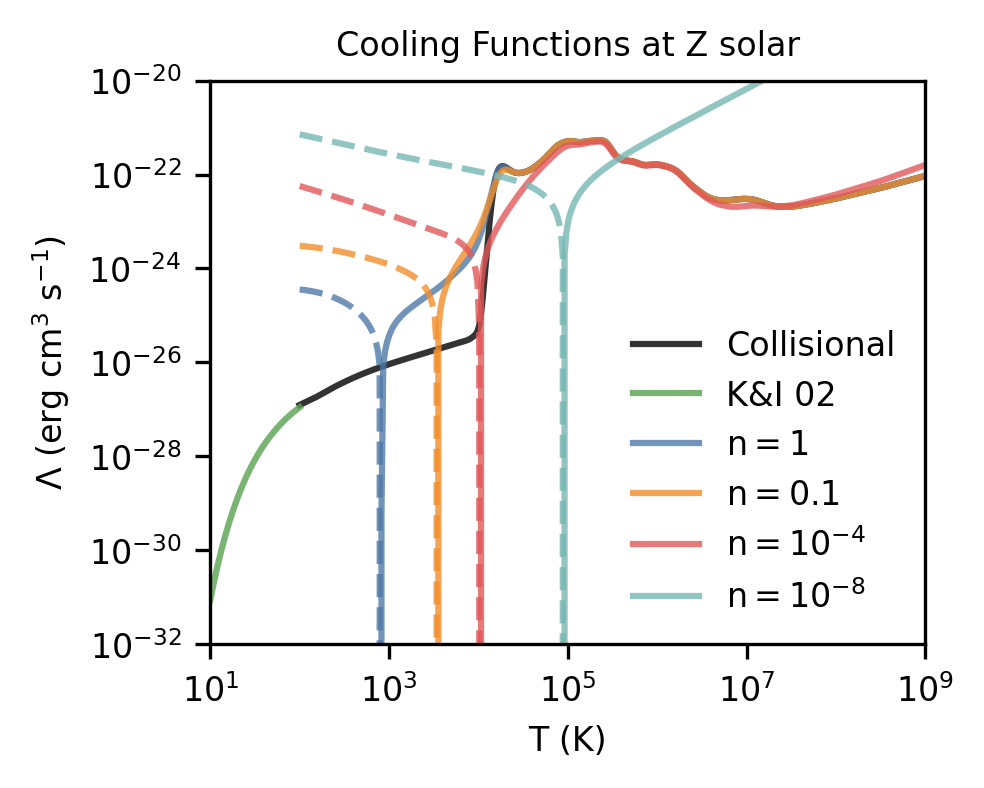

In [89]:
latexify(1)
plt.figure()
plt.loglog()

plt.plot(Tbins,np.array(H_He_Cooling2[1]+Metal_Cooling2),alpha=0.8,color='black',label="Collisional")
plt.plot(np.logspace(1,2,100),low_cool,color='C4',alpha=0.8,label='K&I 02')

plt.plot(T,cool_0,c='C0',alpha=0.8,label="n$=1$")
plt.plot(T,-cool_0,ls='--',alpha=0.8,c='C0')
plt.plot(T,cool_1,c='C1',alpha=0.8,label="n$=0.1$")
plt.plot(T,-cool_1,ls='--',alpha=0.8,c='C1')
plt.plot(T,cool_3,c='C2',alpha=0.8,label=r'n$=10^{-4}$')
plt.plot(T,-cool_3,ls='--',alpha=0.8,c='C2')
plt.plot(T,cool_6,c='C3',alpha=0.8,label=r'n$=10^{-8}$')
plt.plot(T,-cool_6,ls='--',alpha=0.8,c='C3')


# plt.plot(np.logspace(1,9,100),ism_cooling,color="grey",label="ISM AthenaK")

plt.legend(frameon=False)
plt.xlim(1e1,1e9)
plt.ylim(1e-32,1e-20)
plt.ylabel(r'$\Lambda$ (erg cm$^3$ s$^{-1}$)')
plt.xlabel(r'T (K)')
plt.title(r'Cooling Functions at Z solar')
plt.tight_layout()
plt.savefig('./plots/cooling_function.pdf',dpi=150)
plt.show()